# Adversarial Training on CIFAR-10 with FGSM and PGD attacks

In this notebook, we perform FGSM (targeted and non-targeted) and PGD attacks on the CIFAR-10 dataset using the Resnet18 model and build models to defend against these attacks using the Adversarial Training mechanism.

## Table of contents
*  **Preparing train and test data and building Resnet model**

    -  Training function

    -  Test function

    -  Trainig and test loss of Resnet18 model on Cifar-10


*  **FGSM**

    - Visualizing 10 selected samples from the dataset

    - FGSM attack function

    -  Creating adversarial examples from samples with the FGSM attack and eps = 1/255

    -  Adversarial Training with FGSM

    - Comparing naturally-trained and adversarially-trained models

    - Evaluating the adversarially-trained model with FGSM against FGSM attack on test data

    - Targeted FGSM
    

*   **PGD**

    - PGD attack function

    - Adversarial Training with PGD

    - Evaluating the adversarially-trained model with PGD against PGD attack on test data


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

import pickle


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01

<a name='name'></a>
### Preparing train and test data and building Resnet model

In [4]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = resnet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


### Training function

In [5]:
def train(epoch, net):
    
    '''
    this function train net on training dataset
    '''

    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

### Test function

In [6]:
def test(epoch, net):

    '''
    This function evaluate net on test dataset
    '''

    global acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return test_loss/len(testloader)

In [7]:
train_losses=[]
test_losses=[]
epochs=40

for epoch in range(0,epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()

In [8]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 80 %


####Training and test loss of Resnet18 model on Cifar-10

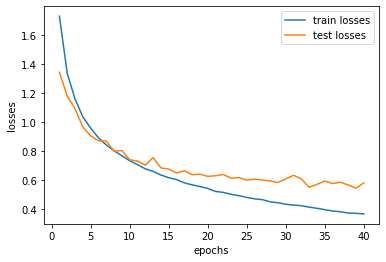

In [9]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

## FGSM

### Visualizing 10 selected samples from the dataset

We need these samples later to make adversarial examples.

In [11]:
imgloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
dataiter = iter(imgloader)
org_images, org_labels = next(dataiter)

In [12]:
org_labels = org_labels.to(device)
org_images = org_images.to(device)
print(org_images.shape)
outputs= net(org_images)
output=outputs.to(device)
print(outputs.shape)
_, predicted = torch.max(outputs.data, 1)

torch.Size([100, 3, 32, 32])
torch.Size([100, 1000])


In [27]:
import random
selected = random.sample(range(0,100),10)


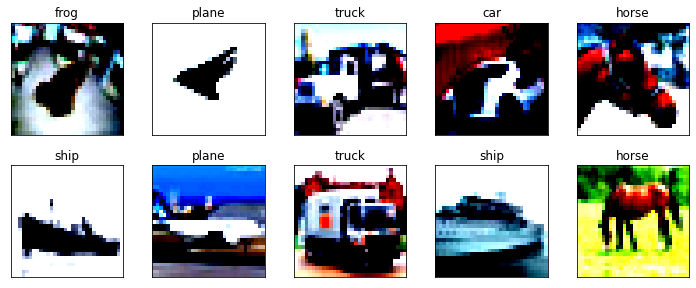

In [28]:
# Plot grid with random batch_size training images with their corresponding label
x_train, y_train = next(iter(imgloader))
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.transpose(x_train[selected[i]], (1, 2, 0)))
    plt.title(classes[y_train[selected[i]]])
plt.tight_layout()
plt.show()

###FGSM attack function
In the FGSM attack, we make adversarial examples using this equation:
$x_{adv}=x_{benign}+\epsilon * sign(\nabla_{x_{benign}}l(\theta, x, y))$

In [29]:
def FGSM(net, x, y, eps):
        '''
        inputs:
            net: the network through which we pass the inputs
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            eps: perturbation budget

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of the last softmax layer when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''

        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert


### Creating adversarial examples from samples with the FGSM attack and eps = 1/255


from left to right: (1/eps) perturbation, original image, adversarial example

true label: 6 adversary label: 3


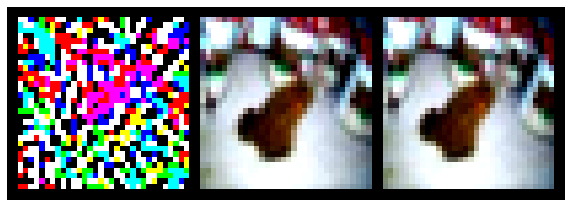

true label: 0 adversary label: 2


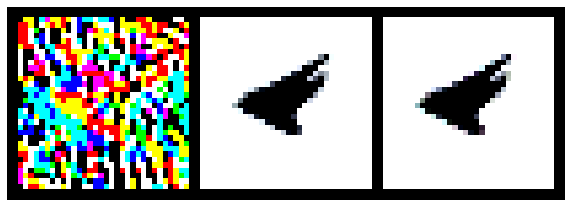

true label: 9 adversary label: 1


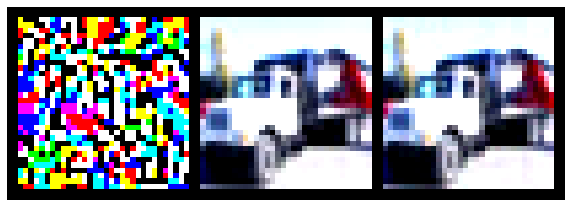

true label: 1 adversary label: 5


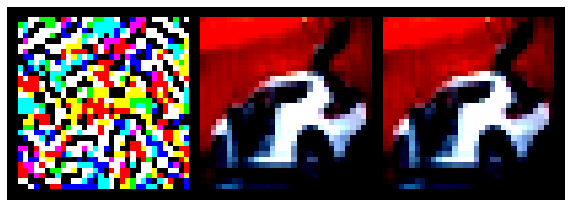

true label: 7 adversary label: 1


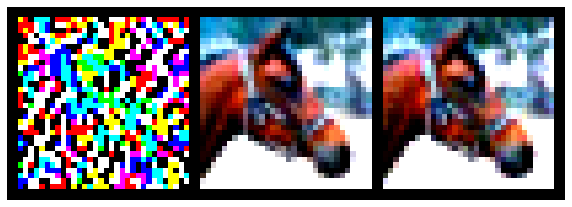

true label: 8 adversary label: 0


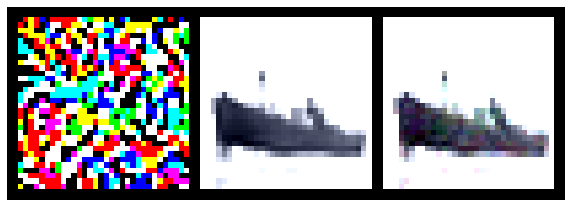

true label: 0 adversary label: 9


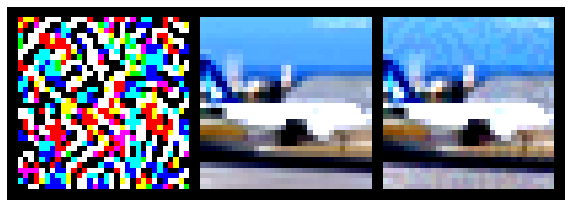

true label: 9 adversary label: 1


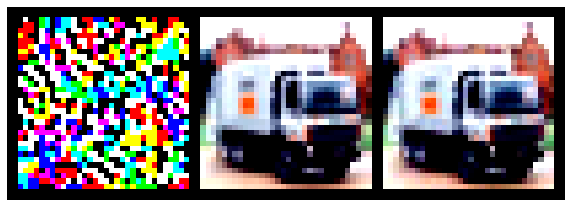

true label: 8 adversary label: 0


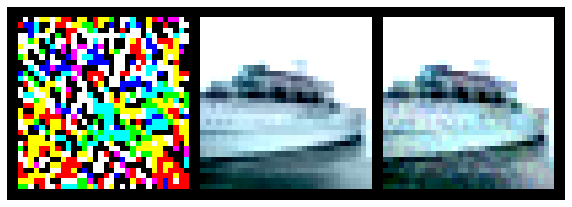

true label: 7 adversary label: 4


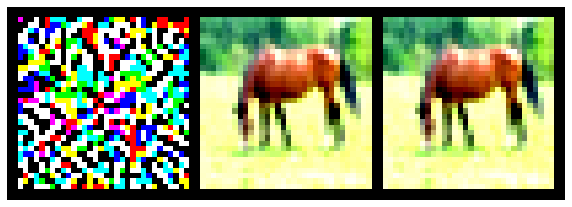

In [30]:
print()
print('from left to right: (1/eps) perturbation, original image, adversarial example')
print()
for i in selected:
    eps=1/255
    while True:
        x_adv, h_adv, y_adv, pert=FGSM(net, org_images[i].unsqueeze_(0),org_labels[i].unsqueeze_(0),eps)
        if y_adv.item()==org_labels[i].item():
            eps=eps+(1/255)
        else:
            break
    print("true label:", org_labels[i].item(), "adversary label:", y_adv.item())
    triple=[]
    with torch.no_grad():
        triple.append((1/eps)*pert.detach().clone().squeeze_(0))
        triple.append(org_images[i])
        triple.append(x_adv.detach().clone().squeeze_(0))
        triple=torch.stack(triple)
        grid = torchvision.utils.make_grid(triple.cpu()/2+0.5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.show()

    

**As you can see, the original and adversarial examples look extremely similar to the human eye.**

### Adversarial Training with FGSM

First, we should build a new model (which we call net_adv) to train on adversarial examples generated by the FGSM attack.

In [31]:
print('==> Building new model..')
net_adv = resnet18()
net_adv = net_adv.to(device)
if device == 'cuda':
    net_adv = torch.nn.DataParallel(net_adv)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_adv = optim.SGD(net_adv.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_adv = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_adv, T_max=200)


==> Building new model..


Train_adv function trains a given neural network on adversarial examples generated from training data using the FGSM attack.



In [32]:
def train_adv(epoch, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs_ = Variable(inputs.data, requires_grad=True)
        h_ = net(inputs_)

        cost = criterion(h_, targets)

        net.zero_grad()
        cost.backward()

        pert= eps*inputs_.grad.detach().sign()
        x_adv = inputs_ + pert

        optimizer_adv.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_adv.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

In [33]:
train_losses_adv=[]
test_losses_adv=[]
epochs=40

for epoch in range(0,epochs):
    train_losses_adv.append(train_adv(epoch, net_adv))
    test_losses_adv.append(test(epoch, net_adv))
    scheduler_adv.step()

In [34]:
print('Accuracy of the network on unperturbed test images: %d %%' % (acc))

Accuracy of the network on unperturbed test images: 77 %


#### Comparing naturally-trained and adversarially-trained models

Train - natural: training loss of the naturally-trained model

Train - adversary: training loss of the adversarially-trained model

Test - natural:  loss of the naturally-trained model on original (unperturbed) test images

Test - adversary: loss of the adversarially-trained model on original (unperturbed) test images

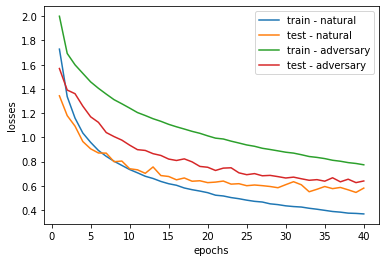

In [35]:
plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

Training losses of the adversarially-trained model are higher than training losses of the naturally-trained model, which is intuitive since the adversarially-trained model is trained against adversarial examples, which makes it harder for the model to label these perturbed inputs correctly and results in higher errors.

The loss of the naturally-trained model on test data is higher than the training loss, since test data is unseen by the model, resulting in higher error in classification.

However, the loss of the adversarially-trained model on test data is lower than the corresponding training loss. This is probably because the test instances are not adversarial (in contrast to training data) and that the model has learned to extract important and useful features, thus performing better on test images.

####Evaluating the adversarially-trained model with FGSM against FGSM attack on test data


Test_adv function constructs adversarial examples from test data (with FGSM using net) and evaluates net_adv on them.

In [37]:
def test_adv(net, net_adv, eps):
    accuracy=0
    net.train()
    net_adv.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, h_adv, y_adv, pert = FGSM (net, inputs, targets, eps)
            
        outputs = net_adv(x_adv)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [38]:
for eps in [4/355, 8/255, 12/255]:
    accuracy=test_adv(net, net_adv, eps)
    print("epsilon:", eps, "accuracy:", accuracy)

epsilon: 0.011267605633802818 accuracy: 77.0
epsilon: 0.03137254901960784 accuracy: 75.69
epsilon: 0.047058823529411764 accuracy: 74.48


We see that **as epsilon increases, the accuracy decreases**, since for bigger epsilons, greater perturbations are allowed, therefore it becomes harder for the model to correctly label those perturbed examples.

### Targeted FGSM

In targeted attacks, we want the model to misclassify its input to the given target class. Therefore, instead of just maximizing the loss of the true label, we maximize the loss of the true label and minimize the loss for the alternative label.

In [39]:
def FGSM_targeted(net,x,y,t,eps):
        '''
        inputs:
            net: the neural network through which we pass the input
            x: the original example which we aim to perturb to make an adversarial example
            y: the true label of x
            t: target label
            eps: perturbation budget

        outputs:
            x_adv : the adversarial example constructed from x
            h_adv: output of the last softmax layer when applying net on x_adv 
            y_adv: predicted label for x_adv
            pert: perturbation applied to x (x_adv - x)
        '''
        
        x_ = Variable(x.data, requires_grad=True)
        h_ = net(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)-criterion(h_,t)
        net.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()
        
        x_adv = x_ + pert

        h_adv = net(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert  

###An example
First, for each example, take as the target class the one having the highest probability in the probability output vector (if it is the same as the true label, choose the class with second-highest probability) and second, take as the target class the one having the lowest probability in the probability output vector (again if it the same as the true label, choose the class with second-lowest probability) and generate adversarial examples using a targeted attack. Compare the accuracy of the adversarially-trained model and naturally-trained model on these examples.

In [40]:
def test_adv_targ(net,model,eps,mode='largest_prob'):
    acc=0
    net.train()
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode=='largest_prob':
            out=net(inputs)
            _,largest=torch.kthvalue(out,10,1)
            _,second_largest=torch.kthvalue(out,9,1)
            condition=largest-targets
            target_adv=torch.where(condition==0,second_largest, largest)
        else:
            out=net(inputs)
            _,smallest=torch.kthvalue(out,1,1)
            _,second_smallest=torch.kthvalue(out,2,1)
            condition=smallest-targets
            target_adv=torch.where(condition==0,second_smallest, smallest)

        x_adv, h_adv, y_adv, pert =FGSM_targeted(net,inputs,targets,target_adv,eps)

        with torch.no_grad():
                outputs = model(x_adv)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

####Class with the **Largest** probability (other than the true class) as the target class for FGSM-targeted attack

In [41]:
eps=8/255
acc1=test_adv_targ(net,net,eps)
acc2=test_adv_targ(net,net_adv,eps)
print("accuracy of naturally trained model against FGSM_targeted attack:",acc1)
print("accuracy of adversarially trained model against FGSM_targeted attack:",acc2)


accuracy of naturally trained model against FGSM_targeted attack: 55.43
accuracy of adversarially trained model against FGSM_targeted attack: 75.35


#### Class with the **Lowest** probability (other than the true class) as the target class for FGSM-targeted attack

In [42]:
eps=8/255
acc1=test_adv_targ(net,net,eps, mode='smallest_prob')
acc2=test_adv_targ(net,net_adv,eps, mode='smallest_prob')
print("accuracy of naturally trained model against FGSM_targeted attack:",acc1)
print("accuracy of adversarially trained model against FGSM_targeted attack:",acc2)


accuracy of naturally trained model against FGSM_targeted attack: 55.6
accuracy of adversarially trained model against FGSM_targeted attack: 75.35


We see that in both cases the accuracy of the adversarially-trained model is much higher than the naturally-trained model since the adversarially-trained model has become more robust and therefore has higher accuracy against adversarial examples.

## PGD
 In the PGD attack, we repeat $
\delta:=\mathcal{P}(\delta+\alpha \nabla_{\delta} l(\theta, x, y))
$
for $t$ iterations.

### PGD attack function

In [43]:
def PGD(net,x,y,alpha,epsilon,iter):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation budget 
        iter: number of iterations in the PGD algorithm

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of the last softmax layer when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    delta = torch.zeros_like(x, requires_grad=True)
    for i in range(iter):
        criterion=nn.CrossEntropyLoss()
        loss = criterion(net(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _,y_adv = torch.max(h_adv.data,1)
    return x_adv, h_adv, y_adv, pert

### Adversarial Training with PGD

First, we should build a new model (which we call net_pgd) to train on adversarial examples generated by the PGD attack.

In [44]:
print('==> Building new model..')
net_pgd = resnet18()
net_pgd = net_pgd.to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_pgd = optim.SGD(net_pgd.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler_pgd = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pgd, T_max=200)


==> Building new model..


Train_pgd function trains a given neural network on adversarial examples generated from training data using the PGD attack.


In [45]:
def train_pgd(epoch, net, alpha, epsilon, iter):
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    eps=8/255
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv,_,_,_ = PGD(net,inputs,targets,alpha,epsilon,iter)

        optimizer_pgd.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pgd.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/len(trainloader)

In [46]:
train_losses_pgd=[]
test_losses_pgd=[]
epochs=40
alpha=3/255
epsilon=8/255
iter=3
for epoch in range(0,epochs):
    train_losses_pgd.append(train_pgd(epoch, net_pgd, alpha, epsilon, iter))
    test_losses_pgd.append(test(epoch, net_pgd))
    scheduler_pgd.step()

In [47]:
print('Accuracy of the network on the test images: %d %%' % (acc))

Accuracy of the network on the test images: 82 %


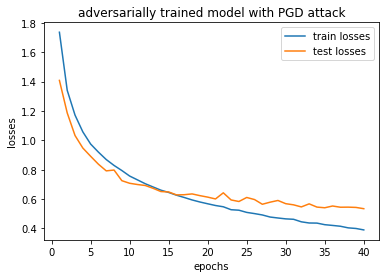

In [48]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses_pgd, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses_pgd, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('adversarially trained model with PGD attack')
plt.legend()
plt.show()

Comparing to previous plots:

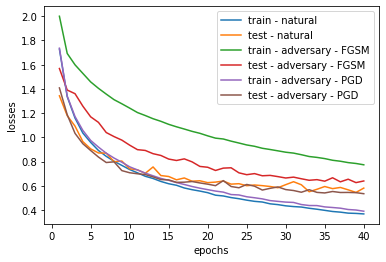

In [49]:
epochs=40
plt.plot(np.arange(1,epochs+1),train_losses, label='train - natural')
plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
plt.plot(np.arange(1,epochs+1),train_losses_adv, label='train - adversary - FGSM')
plt.plot(np.arange(1,epochs+1), test_losses_adv, label='test - adversary - FGSM')
plt.plot(np.arange(1,epochs+1),train_losses_pgd, label='train - adversary - PGD')
plt.plot(np.arange(1,epochs+1), test_losses_pgd, label='test - adversary - PGD')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

Train - natural: training loss of the naturally-trained model

Train - adversary - FGSM: training loss of the adversarially-trained model (on examples generated with FGSM)

Train - adversary - PGD: training loss of the adversarially-trained model (on examples generated with PGD)

Test - natural: loss of the naturally-trained model on original (unperturbed) test images

Test - adversary - FGSM: loss of the adversarially-trained model(on examples generated with FGSM) on original (unperturbed) test images

Test - adversary - PGD: loss of the adversarially-trained model(on examples generated with PGD) on original (unperturbed) test images

### Evaluating the adversarially-trained model with PGD against PGD attack on test data

Test_PGD function constructs adversarial examples from test data (with PGD using net) and evaluates net_pgd on them.



In [50]:
def test_PGD(net,net_pgd,alpha,eps,iter):
    acc=0
    net.train()
    net_pgd.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            x_adv,_,_,_=PGD(net,inputs,targets,alpha,eps,iter)

            with torch.no_grad():
                outputs = net_pgd(x_adv)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
    acc = 100 * correct / total
    return acc

In [51]:
alpha=3/255
eps=8/255
acc1_pgd=[]
for iter in [3,7,12]:
    acc=test_PGD(net,net_pgd,alpha,eps,iter)
    print("accuracy of net_pgd against PGD attack with iters=",iter,": ",acc)

accuracy of net_pgd against PGD attack with iters= 3 :  82.53
accuracy of net_pgd against PGD attack with iters= 7 :  82.09
accuracy of net_pgd against PGD attack with iters= 12 :  81.61


We see that as the iterations increase, the accuracy decreases. The reason is, as the number of iterations increases, the PGD function produces stronger attacks which make it harder for the model to label them correctly. Therefore, the accuracy of the model decreases.

Moreover, as net_pgd was trained on adversary examples produced using PGD attack with 3 iterations, it has a good performance (90%) on similar examples, i.e. for iter=3. However, its accuracy drops against PGD attacks with higher iterations (7 and 12). This is probably because net_pgd was trained with PGD-3 (iter=3) and it is more difficult for it to defend against PGD with 2 or 4 times more iterations.